In [1]:
! pip install openslide-python

In [2]:
from openslide import open_slide
import openslide
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from openslide.deepzoom import DeepZoomGenerator
import torch
import torch.nn as nn


## Visualize image

In [3]:
# Here we can change address of image as per your directory

slide = open_slide("/kaggle/input/tumor-prediction/DI-MH-694-01.svs")

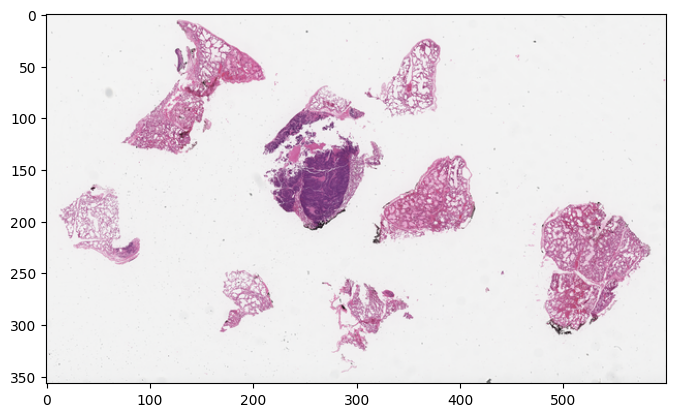

In [4]:
slide_thumb = slide.get_thumbnail(size=(600,600))
slide_thumb_np = np.array(slide_thumb)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_np)

In [5]:
# Edit the input address of Excel file containing labels

import pandas as pd
df  = pd.read_excel("/kaggle/input/tumor-prediction/Fixed NB MKI cases NMYC results short 102523.xlsx")
df

,ID,F/U,NMYC
0,DI-MH-226-07,U,p
1,DI-MH-226-08,F,n
2,DI-MH-226-10,F,n
3,DI-MH-226-11,F,n
4,DI-MH-694-01,NaN,p
5,DI-MH-694-04,NaN,p
6,DI-MH-694-08,NaN,p
7,DI-MH-694-09,NaN,p
8,DI-MH-226-13,U,p
9,DI-MH-694-05,F,n


In [6]:
df.rename(columns={"NMYC":"event"},inplace=True)
df['event']=df['event'].map({"p":1, "n":0})
df

,ID,F/U,event
0,DI-MH-226-07,U,1
1,DI-MH-226-08,F,0
2,DI-MH-226-10,F,0
3,DI-MH-226-11,F,0
4,DI-MH-694-01,NaN,1
5,DI-MH-694-04,NaN,1
6,DI-MH-694-08,NaN,1
7,DI-MH-694-09,NaN,1
8,DI-MH-226-13,U,1
9,DI-MH-694-05,F,0


In [7]:
df.rename(columns={"F/U": "group"},inplace=True)
df

,ID,group,event
0,DI-MH-226-07,U,1
1,DI-MH-226-08,F,0
2,DI-MH-226-10,F,0
3,DI-MH-226-11,F,0
4,DI-MH-694-01,NaN,1
5,DI-MH-694-04,NaN,1
6,DI-MH-694-08,NaN,1
7,DI-MH-694-09,NaN,1
8,DI-MH-226-13,U,1
9,DI-MH-694-05,F,0


In [8]:

from sklearn.model_selection import train_test_split
x=list(df.ID)
x_train,x_valid = train_test_split(x, test_size=1, random_state=2)
x_train, x_valid

(['DI-MH-226-08',
  'DI-MH-694-04',
  'DI-MH-226-07',
  'DI-MH-694-09',
  'DI-MH-226-10',
  'DI-MH-226-11',
  'DI-MH-694-08',
  'DI-MH-694-05',
  'DI-MH-226-13'],
 ['DI-MH-694-01'])

In [9]:
for i in df.ID:
    if i in x_train:
        df['group'][df["ID"]==i]="train"
    else:
        df['group'][df["ID"]==i]="val"
df

/tmp/ipykernel_19/2076228563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'][df["ID"]==i]="train"
/tmp/ipykernel_19/2076228563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'][df["ID"]==i]="train"
/tmp/ipykernel_19/2076228563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'][df["ID"]==i]="train"
/tmp/ipykernel_19/2076228563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

,ID,group,event
0,DI-MH-226-07,train,1
1,DI-MH-226-08,train,0
2,DI-MH-226-10,train,0
3,DI-MH-226-11,train,0
4,DI-MH-694-01,val,1
5,DI-MH-694-04,train,1
6,DI-MH-694-08,train,1
7,DI-MH-694-09,train,1
8,DI-MH-226-13,train,1
9,DI-MH-694-05,train,0


In [10]:
labels = df['event'].values

In [11]:
df.to_csv("labels.csv")

In [12]:
import os
imgs = [i for i in os.listdir("/kaggle/input/tumor-prediction") if i[-3:]=="svs" ]
imgs

['DI-MH-226-07.svs',
 'DI-MH-694-01.svs',
 'DI-MH-226-08.svs',
 'DI-MH-226-10.svs',
 'DI-MH-694-04.svs',
 'DI-MH-226-11.svs',
 'DI-MH-694-09.svs',
 'DI-MH-694-05.svs',
 'DI-MH-226-13.svs',
 'DI-MH-694-08.svs']

In [13]:
# items_to_remove=["DI-MH-243-06.svs","DI-MH-243-08.svs", "DI-MH-694-06.svs", "DI-MH-243-01.svs", 'DI-MH-226-05.svs']
# for i in items_to_remove:
#     imgs.remove(i)
# imgs, len(imgs)

## Creating tiles and storing

In [14]:


# Set parameters
tile_size = 512  # Tile size (width and height)
# num_tiles = 20  # The number of tiles in each dimension (e.g., 10x10 grid)

# Create directories
if not os.path.exists("/kaggle/working/images/"):
    os.makedirs("/kaggle/working/images/")
    

if not os.path.exists("/kaggle/working/images/val/"):
    os.makedirs("/kaggle/working/images/val/")

for img_name in imgs:
    group = df['group'][df['ID'] == img_name[:-4]].values[0]
    if group == 'val':
        tile_dir = "/kaggle/working/images/val/"
    

        tile_dir = os.path.join(tile_dir, img_name[:-4])
    
        if not os.path.exists(tile_dir):
            os.makedirs(tile_dir)
    
        slide = open_slide(f"/kaggle/input/tumor-prediction/{img_name}")
        tiles = DeepZoomGenerator(slide, tile_size=tile_size, overlap=0, limit_bounds=False)

        # Calculate the number of tiles
        level = 12  # Highest resolution
        total_cols, total_rows = tiles.level_dimensions[level]
        max_col = total_cols // tile_size
        max_row = total_rows // tile_size
    
        for row_index in range(max_row):
            for col_index in range(max_col):
                tile_name = os.path.join(tile_dir, f"{col_index}_{row_index}.jpg")
                temp_tile = tiles.get_tile(level, (col_index, row_index))
                temp_tile_rgb = temp_tile.convert("RGB")
                tmp_tile_np = np.array(temp_tile_rgb)
                plt.imsave(tile_name, tmp_tile_np)
#                 print(f"{tile_name} saved to val")


In [15]:
df_val = pd.read_csv("labels.csv")

In [16]:
df_val=df_val.drop('Unnamed: 0', axis=1)
df_val = df_val[df_val['group'] != 'train']
df_val

,ID,group,event
4,DI-MH-694-01,val,1


## Transforming tiles(patches) images into tensors

In [17]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Load label information
# labels_df = pd.read_csv('path/to/labels.csv')

# Create a dictionary to map image IDs to labels
label_dict = {row['ID']: row['event'] for _, row in df.iterrows()}

# Custom Dataset
class PatchDataset(Dataset):
    def __init__(self, root_dir, group, transform=None):
        self.root_dir = os.path.join(root_dir, group)
        self.image_ids = os.listdir(self.root_dir)
        self.group = group
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_dir = os.path.join(self.root_dir, image_id)
        patches = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        images = []
        for patch in patches:
            img = Image.open(patch).convert('RGB')
            if self.transform:
                img = self.transform(img)
            images.append(img)
        images = torch.stack(images)
        label = label_dict[image_id]
        label = torch.tensor(label, dtype=torch.long)  # Ensure the label is a long tensor
        return images, label


# # Define transform
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Rotates by +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example values
])


In [18]:
# Create datasets and dataloaders
# You can change batch size here I have only 10 images So, I use batch size of 1
val_dataset = PatchDataset('/kaggle/working/images', 'val', transform=transform)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


## Model Architecture

In [19]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, hidden_dim, num_classes):
        super(Attention, self).__init__()
        self.encoder_dim = encoder_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.attention_layer = nn.Sequential(
            nn.Linear(encoder_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Linear(encoder_dim, num_classes)

    def forward(self, features):
        attention_weights = torch.softmax(self.attention_layer(features), dim=0)
        weighted_features = features * attention_weights
        aggregated_features = torch.sum(weighted_features, dim=0)
        classification = self.classifier(aggregated_features)
        return classification, attention_weights


In [20]:
class MILModel(nn.Module):
    def __init__(self, base_model, attention_dim, hidden_dim, num_classes):
        super(MILModel, self).__init__()
        self.base_model = base_model
        self.attention = Attention(attention_dim, hidden_dim, num_classes)

    def forward(self, x):
        # Assuming x is a batch of image tiles
        if x.dim() == 4:  # If x is [num_tiles, c, h, w]
            x = x.unsqueeze(0)  # Add the batch dimension, now x is [1, num_tiles, c, h, w]
        batch_size, num_tiles, c, h, w = x.size()
        x = x.view(-1, c, h, w)  
        features = self.base_model(x)
        features = features.view(batch_size, num_tiles, -1)  # Reshape to (batch_size, num_tiles, feature_dim)
        output, attention_weights = self.attention(features)
        return output, attention_weights


## Compiling model and loading pretrained weights

In [21]:
encoder = models.resnet18(pretrained=True)
encoder_dim = encoder.fc.in_features
encoder.fc = nn.Identity()  # We only want the features, not the final classification
hidden_dim = 128
num_classes = 2  # Example for binary classification

model = MILModel(encoder, encoder_dim, hidden_dim, num_classes)
model.load_state_dict(torch.load("/kaggle/input/tumor-prediction/best_model_epoch.pth"))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


<All keys matched successfully>

In [22]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-----------------------------------------+------------+
|                 Modules                 | Parameters |
+-----------------------------------------+------------+
|         base_model.conv1.weight         |    9408    |
|          base_model.bn1.weight          |     64     |
|           base_model.bn1.bias           |     64     |
|     base_model.layer1.0.conv1.weight    |   36864    |
|      base_model.layer1.0.bn1.weight     |     64     |
|       base_model.layer1.0.bn1.bias      |     64     |
|     base_model.layer1.0.conv2.weight    |   36864    |
|      base_model.layer1.0.bn2.weight     |     64     |
|       base_model.layer1.0.bn2.bias      |     64     |
|     base_model.layer1.1.conv1.weight    |   36864    |
|      base_model.layer1.1.bn1.weight     |     64     |
|       base_model.layer1.1.bn1.bias      |     64     |
|     base_model.layer1.1.conv2.weight    |   36864    |
|      base_model.layer1.1.bn2.weight     |     64     |
|       base_model.layer1.1.bn2

11243331

## Model Evaluation

In [23]:


from sklearn.metrics import accuracy_score, f1_score
torch.load
y_true = []
y_pred = []
val_loss = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:
#         print(inputs)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Aggregate patch outputs
        outputs = outputs.mean(dim=0, keepdim=True)

        # Get the predictions
        _, preds = torch.max(outputs, 1)
        
        # Make sure targets is 1D
        targets = targets.squeeze()  # Remove any extra dimensions

#         loss = criterion(outputs, targets)
#         val_loss += loss.item()
        y_true.append(targets.item())  # Since targets is now 0D, use .item()
        y_pred.append(preds.item())

# Calculate metrics for the current fold
fold_accuracy = accuracy_score(y_true, y_pred)
fold_f1_score = f1_score(y_true, y_pred, average='weighted')
print(f"| Accuracy: {fold_accuracy} | F1 Score: {fold_f1_score}")


| Accuracy: 0.0 | F1 Score: 0.0


In [24]:
from sklearn.metrics import classification_report

# Calculate metrics for the current fold
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [25]:
# ! rm -r /kaggle/working/images/test2

## Testing model over any perticular image

In [26]:
##### import random
import numpy as np
import matplotlib.pyplot as plt
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
from torchvision import transforms
from PIL import Image

# Function to preprocess the image
import os
import numpy as np
import matplotlib.pyplot as plt
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
from PIL import Image

class testPatchDataset(Dataset):
    def __init__(self, root_dir, group, transform=None):
        self.root_dir = os.path.join(root_dir, group)
        self.image_ids = os.listdir(self.root_dir)
        self.group = group
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_dir = os.path.join(self.root_dir, image_id)
        patches = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        images = []
        for patch in patches:
            img = Image.open(patch).convert('RGB')
            if self.transform:
                img = self.transform(img)
            images.append(img)
        images = torch.stack(images)
        return images


# # Define transform
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Rotates by +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example values
])


def create_tiles(img_name, root_dir="/kaggle/working/images/", tile_size=512):
    """
    Create tiles from images based on the provided parameters.

    Parameters:
    - imgs: List of image names
    - df: DataFrame containing image information including groups (e.g., 'train', 'val')
    - root_dir: Root directory to save the tiles
    - tile_size: Size of each tile (width and height)
    - num_tiles: The number of tiles in each dimension (e.g., 10x10 grid)
    """
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)
    
    if not os.path.exists(f"{root_dir}/test3"):
        os.makedirs(f"{root_dir}/test3")



    tile_dir = os.path.join(root_dir, "test3", img_name[:-4])

    if not os.path.exists(tile_dir):
        os.makedirs(tile_dir)

    slide = open_slide(f"/kaggle/input/tumor-prediction/{img_name}")
    tiles = DeepZoomGenerator(slide, tile_size=tile_size, overlap=0, limit_bounds=False)

    # Calculate the number of tiles
    level = 14  # Highest resolution
    total_cols, total_rows = tiles.level_dimensions[level]
    max_col = total_cols // tile_size
    max_row = total_rows // tile_size

    for row_index in range(max_row):
        for col_index in range(max_col):
            tile_name = os.path.join(tile_dir, f"{col_index}_{row_index}.jpg")
            temp_tile = tiles.get_tile(level, (col_index, row_index))
            temp_tile_rgb = temp_tile.convert("RGB")
            tmp_tile_np = np.array(temp_tile_rgb)
            plt.imsave(tile_name, tmp_tile_np)
#             print(f"{tile_name} saved to val")
    print("tile_completed")
    

# Example usage


# Select a random image
def Tester(img_path):
    img_name = img_path.split("/")[-1]
    test_tensor = create_tiles(img_name)
    test_dataset = testPatchDataset('/kaggle/working/images', 'test3', transform=transform)

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



    with torch.no_grad():
        for inputs in test_loader:
            print("start")
    #         print(inputs)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            outputs = outputs.mean(dim=0, keepdim=True)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence_score, predicted_label = torch.max(probabilities, 1)
            print("get output")

            _, predicted_label = torch.max(outputs, 1)
            targets = predicted_label.squeeze()

    #        

    # Visualize the image and predicted label
    # plt.figure(figsize=(12, 6))
    out = ['Positive' if targets.item()==1 else 'Negative']
    plt.subplot(1, 2, 1)
    original_image = open_slide(f"/kaggle/input/tumor-prediction/{img_name}")
    slide_thumb = original_image.get_thumbnail(size=(800,800))
    slide_thumb_np = np.array(slide_thumb)
    plt.imshow(slide_thumb_np)
    plt.title(f'Predicted Label: {out[0]}\nConfidence Score: {confidence_score.item():.4f}')
    return inputs, outputs


## Edit input address for test image and run shell to see outputs

rm: cannot remove '/kaggle/working/images/test3': No such file or directory
tile_completed
start
get output


(tensor([[[[[-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727],
            [-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727],
            [-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727],
            ...,
            [-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727],
            [-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727],
            [-1.6727, -1.6727, -1.6727,  ..., -1.6727, -1.6727, -1.6727]],
 
           [[-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805],
            [-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805],
            [-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805],
            ...,
            [-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805],
            [-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805],
            [-1.5805, -1.5805, -1.5805,  ..., -1.5805, -1.5805, -1.5805]],
 
           [[-1.3513, -1.3513, -1.3513,  ..., -1.3513, -1.3513, -1.3513]

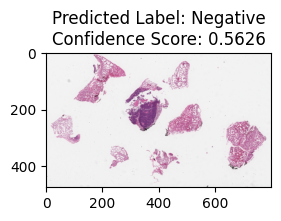

In [27]:
! rm -r /kaggle/working/images/test3
input_address  ="/kaggle/input/tumor-prediction/DI-MH-694-01.svs"
Tester(input_address)

tile_completed
start
get output


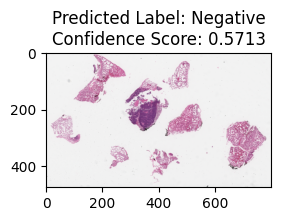

In [28]:
batch_size = 1
x = torch.randn(batch_size, 3, 320, 320, requires_grad=True)
x, y = Tester(input_address)

In [29]:
torch.onnx.export(model, x, "model.onnx", export_params=True, opset_version=11, do_constant_folding=True, input_names = ['input'], output_names = ['output'], dynamic_axes = {'input' : {0: 'batch_size'}, 'output': {0: 'batch_size'}})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

